# ASSIGNMENT 6

## Submitted by - 
    Raghav Aggarwal 20EC10064 (Team Leader)
    Darpan Aswal 20EC10026
    Rudransh Gupta 20EE30036
    Parv Jain 20IE10048
    Adarsh Jha 20CH30003
    Harsh Gupta 20CH10021
## Importing Libraries and Dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.spatial
from scipy import stats
import statistics
from tqdm import tqdm
from collections import Iterable
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

dataset = pd.read_csv('Twitter_data.csv', low_memory = False)
dataset.drop(['TweetID', ' UserID', ' text'], inplace=True, axis=1)

## Taking Care of Missing Data and Shuffling

In [4]:
dataset = dataset.dropna(axis=0)
dataset = dataset.sample(frac=1)

## Converting Categorical Data to Numerical Type

In [24]:
dataset['Day'].replace(['Thursday', 'Friday', 'Saturday', 'Sunday'], [0, 1, 2, 3], inplace=True)
dataset[' Lang'].replace(['en', '_u'], [0, 1], inplace=True)
dataset[' IsReshare'].replace(['TRUE', 'FALSE'], [1, 0], inplace=True)

X = dataset.iloc[:, 1:].values
Y = dataset.iloc[:, 0].values

## Splitting the dataset

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 1234)

## Defining Functions

In [30]:
def eu_distance(x1,x2):
    return np.sqrt(np.sum(np.square(x2-x1)))

def flatten(lis):
     return list(np.concatenate(lis).flat)

def accuracy(X,Y,clusters,labels_list):
    count=0
    for k,cluster in enumerate(clusters):
        for idx in cluster:
            if(Y.iloc[idx,0]==labels_list[k]):
                count+=1
    return count/len(X)      

def train_accuracy(X,Y,clusters,labels_list):
    correct=0
    for k,cluster in enumerate(clusters):
        for idx in cluster:
            if(Y.iloc[idx,0]==labels_list[k]):
                correct+=1
    return correct/len(X)

def test_accuracy(X_test,Y_test,X,Y,clusters,labels_list):
    count=0
    cluster_centres=[]
    label_map = np.zeros((len(X),))
    pred_labels=[]
    for k,cluster in enumerate(clusters):
        arr = np.array([X.iloc[idx,:] for idx in cluster])
        mean = np.mean(arr,axis=0)
        cluster_centres.append(mean)
        for idx in cluster:
            label_map[idx]=labels_list[k]
    test_dist = scipy.spatial.distance.cdist(X_test,X)
    for i in range(len(X_test)):
        closest = np.argmin(np.array(test_dist[i]))
        pred_labels.append(label_map[closest])
        if(label_map[closest]==Y_test.iloc[i,0]):
            count+=1
    return count/len(X_test),pred_labels,label_map,cluster_centres

# PART I (SINGLE MODEL)

In [8]:
# mutual distances array calculated only once very efficiently
dist_arr = scipy.spatial.distance.cdist(X,X)
for i in range(len(X)):
    dist_arr[i,i]=1e9

In [9]:
# initialising all data points as separate clusters
levels = {}
clusters =[]
for i in range(len(X)):
    clusters.append([i])
levels[str(len(clusters))] = clusters.copy()

In [16]:
# calculating the complete tree with single linkage
def generator():
    while len(clusters)>1:
        yield

for _ in tqdm(generator()):
    curr_arr = np.zeros((len(clusters),len(clusters)))
    for i in range(len(clusters)):
        for j in range(len(clusters)):
            if(i==j):
                curr_arr[i,j]=1e9
                continue
            min=1e9
            for idx_i in clusters[i]:
                for idx_j in clusters[j]:
                    if(min>dist_arr[idx_i,idx_j]):
                        min=dist_arr[idx_i,idx_j]
            curr_arr[i,j]=min
    
    prev_clusters = clusters.copy()
    i,j = np.argwhere(curr_arr == np.min(curr_arr))[0]
    clusters.pop(i)
    if(i!=j):
        if(i>j):
            clusters.pop(j)
        else:
            clusters.pop(j-1)
    clusters.append(list(flatten([prev_clusters[i],prev_clusters[j]])))
    
    levels[str(len(clusters))] = clusters.copy()

991it [09:33,  1.73it/s]


In [36]:
Y = pd.DataFrame(Y)
X = pd.DataFrame(X)

In [28]:
level_cut = 100

clusters = levels[str(level_cut)]
labels_list=[]
for cluster in clusters:
    labels = np.array([Y.iloc[i,0] for i in cluster])
    label = stats.mode(labels)[0]
    labels_list.append(label)

In [51]:
print('Train Accuracy: ',train_accuracy(X,Y,clusters,labels_list))

Train Accuracy:  0.3226452905811623


In [37]:
test_acc,pred_labels,label_map,cluster_centres = test_accuracy(X_test,Y_test,X,Y,clusters,labels_list)
print('Test Accuracy: ',test_acc)

Test Accuracy:  0.48


In [38]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')
model = model.fit(X,Y)

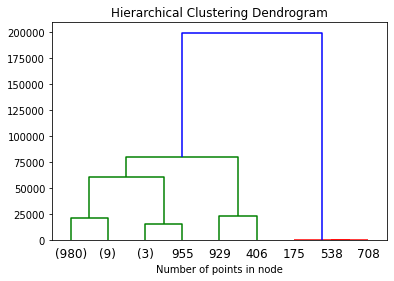

In [39]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node")
plt.show()

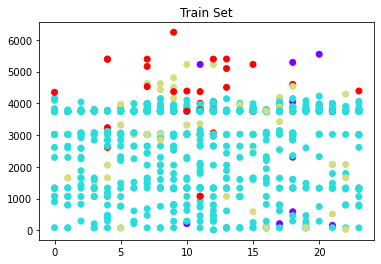

In [40]:
plt.title("Train Set")
plt.scatter(X.iloc[:,0],X.iloc[:,7],c=label_map,cmap='rainbow')
plt.show()

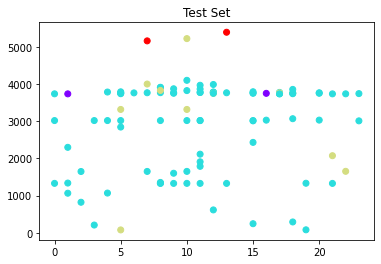

In [42]:
X_test = pd.DataFrame(X_test)
plt.title("Test Set")
plt.scatter(X_test.iloc[:,0],X_test.iloc[:,7],c=pred_labels,cmap='rainbow')
plt.show()

# PART II (COMPLETE MODEL)

In [48]:
dist_arr = scipy.spatial.distance.cdist(X,X)
for i in range(len(X)):
    dist_arr[i,i]=1e9

In [49]:
levels = {}
clusters =[]
for i in range(len(X)):
    clusters.append([i])
levels[str(len(clusters))] = clusters.copy()

In [50]:
# calculating the complete tree with complete linkage
def generator2():
    while len(clusters)>1:
        yield

for _ in tqdm(generator2()):
    curr_arr = np.zeros((len(clusters),len(clusters)))
    for i in range(len(clusters)):
        for j in range(len(clusters)):
            if(i==j):
                curr_arr[i,j]=1e9
                continue
            max=0
            for idx_i in clusters[i]:
                for idx_j in clusters[j]:
                    if(max<dist_arr[idx_i,idx_j] and dist_arr[idx_i,idx_j]!=1e9):
                        max=dist_arr[idx_i,idx_j]
            curr_arr[i,j]=max
    
    prev_clusters = clusters.copy()
    i,j = np.argwhere(curr_arr == np.min(curr_arr))[0]
    clusters.pop(i)
    if(i!=j):
        if(i>j):
            clusters.pop(j)
        else:
            clusters.pop(j-1)
    clusters.append(list(flatten([prev_clusters[i],prev_clusters[j]])))
    
    levels[str(len(clusters))] = clusters.copy()

997it [14:11,  1.17it/s]


In [52]:
level_cut = 100

clusters = levels[str(level_cut)]
labels_list=[]
for cluster in clusters:
    labels = np.array([Y.iloc[i,0] for i in cluster])
    label = stats.mode(labels)[0]
    labels_list.append(label)

In [55]:
print('Train Accuracy: ',train_accuracy(X,Y,clusters,labels_list))

Train Accuracy:  0.4939879759519038


In [56]:
test_acc,pred_labels,label_map,cluster_centres = test_accuracy(X_test,Y_test,X,Y,clusters,labels_list)
print('Test Accuracy: ',test_acc)

Test Accuracy:  0.55


In [57]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
model = model.fit(X,Y)

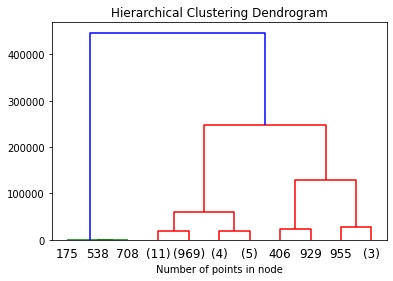

In [58]:

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node")
plt.show()

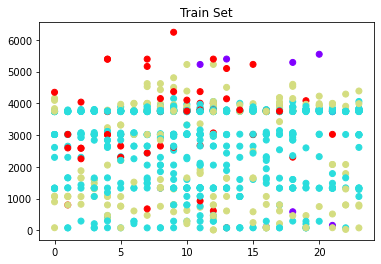

In [59]:
plt.title("Train Set")
plt.scatter(X.iloc[:,0],X.iloc[:,7],c=label_map,cmap='rainbow')
plt.show()

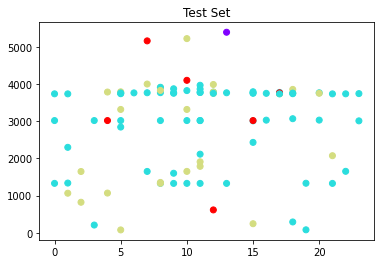

In [60]:
plt.title("Test Set")
plt.scatter(X_test.iloc[:,0],X_test.iloc[:,7],c=pred_labels,cmap='rainbow')
plt.show()